In [1]:
# way to define spark context
import findspark
findspark.init()
from pyspark.sql import SparkSession


In [2]:
spark = SparkSession.builder\
    .appName("Reddit_proj") \
    .config("spark.jars", "postgresql-42.7.5.jar") \
    .getOrCreate()
sc = spark.sparkContext

In [3]:
from datetime import datetime 
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, col, to_timestamp, stack, expr, lit, split, sum, udf, regexp_replace, size
from pyspark.sql.types import TimestampType, StructField, StructType, StringType, DoubleType, IntegerType, ArrayType
import os

In [4]:
posts_schema = StructType([
    StructField("post_id", StringType(), True),
    StructField("title", StringType(), True),
    StructField("author", StringType(), True),
    StructField("score", IntegerType(), True),
    StructField("num_comments", IntegerType(), True),
    StructField("created_utc", DoubleType(), True),
    StructField("subreddit", StringType(), True),
    StructField("post_url", StringType(), True),
    StructField("selftext", StringType(), True)
])

In [5]:
comments_schema = StructType([
    StructField("comment_id", StringType(), True),
    StructField("author", StringType(), True),
    StructField("score", IntegerType(), True),
    StructField("created_utc", DoubleType(), True),
    StructField("parent_id", StringType(), True),
    StructField("link_id", StringType(), True),
    StructField("body", StringType(), True)
])

In [6]:
df_posts = spark.read.csv("posts_travel_cleaned.csv",
                        header=True,
                        schema=posts_schema)

df_comments = spark.read.csv("comments_travel_cleaned.csv",
                            header=True,
                            schema=comments_schema)

In [7]:
df_posts.printSchema()

root
 |-- post_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- author: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- num_comments: integer (nullable = true)
 |-- created_utc: double (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- post_url: string (nullable = true)
 |-- selftext: string (nullable = true)



In [8]:
df_comments.printSchema()

root
 |-- comment_id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- created_utc: double (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- body: string (nullable = true)



In [9]:
df_posts.count()

60

In [10]:
#Casting the df_posts["created_utc"] to time stamp
df_posts = df_posts.withColumn("created_utc", df_posts["created_utc"].cast(TimestampType()))


In [11]:
df_posts.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_posts.columns]).show()

+-------+-----+------+-----+------------+-----------+---------+--------+--------+
|post_id|title|author|score|num_comments|created_utc|subreddit|post_url|selftext|
+-------+-----+------+-----+------------+-----------+---------+--------+--------+
|      0|    0|     0|    0|           0|          0|        0|       0|       0|
+-------+-----+------+-----+------------+-----------+---------+--------+--------+



In [12]:
df_posts.select("*").show(5)

+-------+--------------------+--------------------+-----+------------+-------------------+---------+--------------------+--------------------+
|post_id|               title|              author|score|num_comments|        created_utc|subreddit|            post_url|            selftext|
+-------+--------------------+--------------------+-----+------------+-------------------+---------+--------------------+--------------------+
|1mnkqmi|Advice on travel ...|             gtjs001|    1|           1|2025-08-11 21:17:48|   travel|https://www.reddi...|My wife and I are...|
|1mnkabx|Night time in London|             Areotew|    0|           9|2025-08-11 21:01:10|   travel|https://www.reddi...|I have found myse...|
|1mnk8sc|Things to do in R...|      Ok_Hearing7948|    1|           1|2025-08-11 20:59:41|   travel|https://www.reddi...|I’ll be spending ...|
|1mnk0m9|Malaysia in Septe...|     AdagioNovel1264|    1|           1|2025-08-11 20:51:16|   travel|https://www.reddi...|Hello,me and my g...|

In [13]:
# df_comments column created_utc cast to timeStamp 
df_comments = df_comments.withColumn("created_utc", df_comments["created_utc"].cast(TimestampType()))


In [14]:
df_comments.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_comments.columns]).show()

+----------+------+-----+-----------+---------+-------+----+
|comment_id|author|score|created_utc|parent_id|link_id|body|
+----------+------+-----+-----------+---------+-------+----+
|         0|     0|    0|          0|        0|      0|   0|
+----------+------+-----+-----------+---------+-------+----+



In [15]:
df_comments.select("*").show(5)

+----------+----------------+-----+-------------------+----------+----------+--------------------+
|comment_id|          author|score|        created_utc| parent_id|   link_id|                body|
+----------+----------------+-----+-------------------+----------+----------+--------------------+
|   n85i14a|   AutoModerator|    1|2025-08-11 21:17:49|t3_1mnkqmi|t3_1mnkqmi|Notice: Are you a...|
|   n85fd9z|NewJerseyAggie13|    1|2025-08-11 21:04:40|t3_1mnkabx|t3_1mnkabx|London has severa...|
|   n85gih8|           ZKH15|    1|2025-08-11 21:10:18|t3_1mnkabx|t3_1mnkabx|As a Londoner, I’...|
|   n85gttp|    UnhappyScore|    1|2025-08-11 21:11:51|t3_1mnkabx|t3_1mnkabx|If its the weeken...|
|   n85fl96|        gateofai|    1|2025-08-11 21:05:45|t3_1mnkabx|t3_1mnkabx|Nothing really ev...|
+----------+----------------+-----+-------------------+----------+----------+--------------------+
only showing top 5 rows



In [16]:
# printing Schema agian
df_posts.printSchema()
df_comments.printSchema()

root
 |-- post_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- author: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- num_comments: integer (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- post_url: string (nullable = true)
 |-- selftext: string (nullable = true)

root
 |-- comment_id: string (nullable = true)
 |-- author: string (nullable = true)
 |-- score: integer (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- body: string (nullable = true)



In [17]:
#df_posts.write.format("delta").mode("overwrite").saveAsTable(f"workspace.default.reddit_posts_travel")

In [18]:
#df_comments.write.format("delta").mode("overwrite").saveAsTable(f"workspace.default.reddit_comments_travel")

In [ ]:
#pip install pycountry geonamescache unidecode


In [17]:
import geonamescache

gc = geonamescache.GeonamesCache()

# Get country names
countries_name =  gc.get_countries_by_names()


def NER_func_city(word):
    res = gc.get_cities_by_name(word.capitalize())
    if res == []:
        return []
    else:
        # use res[0] to get first element
        first_key = next(iter(res[0])) # used next and iter to get first element in the dict res[0]
        country_code = res[0][first_key]["countrycode"] # used the key to get country code from the dict that found in res[0]
        country = gc.get_countries() # used this function to get countries by code
        country_name = country[country_code]['name'] # get the country name

    return country_name     

def NER_func_country(text):
    text = text.split(" ")
    countries = set()
    for word in text:
        #print(word)
        if word.capitalize() in countries_name:
            countries.add(word)
        else:
            val = NER_func_city(word)
            if val == []:
                continue
            else:

                countries.add(val) 
    return list(countries) 

 

In [18]:
NER_func_country('We were there in May and spent 4 nights in Lisbon  2 nights in Coimbra  and 4 nights in Porto   Coimbra is an old university city  with the oldest extant ')

['Portugal', 'United States']

In [19]:
df_comments = df_comments.withColumn("body", regexp_replace("body", r"[^a-zA-Z0-9 ]", " "))

In [20]:

udf_search_country = udf(NER_func_country, ArrayType(StringType()))


In [21]:
#df_comments = df_comments.withColumn("city_name", udf_search_city(df_comments["body"]))
df_comments = df_comments.withColumn("country_name", udf_search_country(df_comments["body"]))

In [22]:
df_comments[["country_name","body"]].show(5, truncate=False)

+----------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|country_name                                        |body                                                                                                                                                                                                                            

In [24]:
df_comments_2 = df_comments.filter(size(col("country_name")) > 0)

In [320]:
df_comments_2.write.parquet("df_comments_cleaned_2_NO_NLP_Sentiment.parquet")

In [25]:
df_comments_2 = df_comments_2.select("*", explode(col("country_name")))

In [28]:
df_comments_2 = df_comments_2.drop(("country_name"))

In [29]:
df_comments_2 = df_comments_2.withColumnRenamed("col","country_name")

In [30]:
df_comments_2.show(5)

+----------+----------------+-----+-------------------+----------+----------+--------------------+-------------+
|comment_id|          author|score|        created_utc| parent_id|   link_id|                body| country_name|
+----------+----------------+-----+-------------------+----------+----------+--------------------+-------------+
|   n85i14a|   AutoModerator|    1|2025-08-11 21:17:49|t3_1mnkqmi|t3_1mnkqmi|Notice  Are you a...|       Turkey|
|   n85i14a|   AutoModerator|    1|2025-08-11 21:17:49|t3_1mnkqmi|t3_1mnkqmi|Notice  Are you a...|      Croatia|
|   n85fd9z|NewJerseyAggie13|    1|2025-08-11 21:04:40|t3_1mnkabx|t3_1mnkabx|London has severa...|       Canada|
|   n85gih8|           ZKH15|    1|2025-08-11 21:10:18|t3_1mnkabx|t3_1mnkabx|As a Londoner  I ...|      Czechia|
|   n85gih8|           ZKH15|    1|2025-08-11 21:10:18|t3_1mnkabx|t3_1mnkabx|As a Londoner  I ...|United States|
+----------+----------------+-----+-------------------+----------+----------+-------------------

In [31]:
df_comments_2.count()

682

In [32]:
df_comments_2.write.parquet("df_comments_cleaned_2_NO_NLP_Sentiment_2.parquet")

# Applying some Aggregations on data

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

In [67]:
df_comments_pandas = df_comments_2.toPandas()

In [52]:
df_comments_pandas.to_csv("df_final_comments_gold_layer.csv",index=False)

In [56]:
df_countries = df_comments_pandas.groupby(by=["country_name"])["comment_id"].agg("count").reset_index()

In [65]:
df_countries = df_countries.rename(columns={'comment_id':"countries_count"})
df_countries.head()

,country_name,countries_count
0,Albania,1
1,Argentina,4
2,Australia,5
3,Austria,6
4,Belgium,3


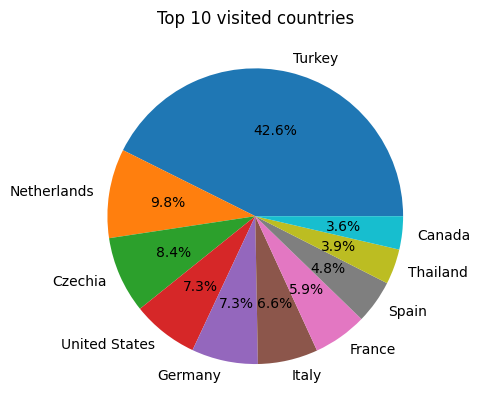

In [86]:
top_10_countries = df_countries.sort_values(by="countries_count",ascending=False).head(10)
ax = top_10_countries.plot(y='countries_count', labels=top_10_countries['country_name'],autopct='%1.1f%%',
                     kind='pie', title='Top 10 visited countries',legend=False)
ax.yaxis.set_visible(False)
plt.show()


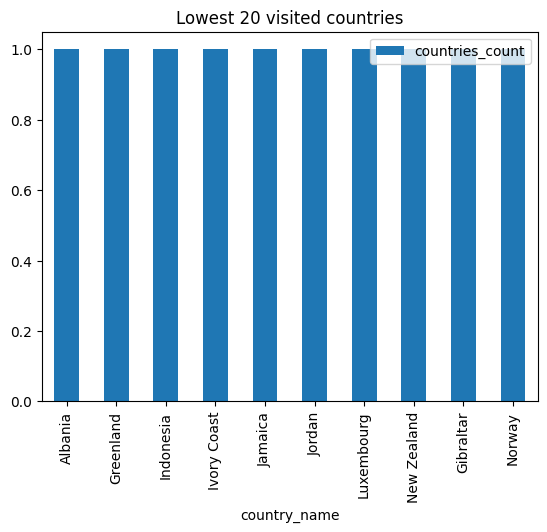

In [75]:
lowest_10_countries = df_countries.sort_values(by="countries_count",ascending=True).head(10)
lowest_10_countries.plot(x='country_name', y='countries_count', kind='bar', title='Lowest 20 visited countries')
plt.show()

In [60]:
avg_score = df_comments_pandas["score"].mean()
max_score = df_comments_pandas["score"].max()
min_score = df_comments_pandas["score"].min()
avg_score,max_score,min_score

(3.4765395894428153, 83, -4)

In [62]:
top_10_scores = df_comments_pandas[["score","comment_id","author"]].sort_values(by="score",ascending=False).head(10)
top_10_scores

,score,comment_id,author
380,83,n83r1u4,pulisick38
381,83,n83r1u4,pulisick38
473,51,n83o7mp,coaxui
474,51,n83o7mp,coaxui
331,41,n840e7s,pabloelbuho
630,33,n82tz3i,bungopony
629,33,n82tz3i,bungopony
628,33,n82tz3i,bungopony
471,31,n83oqbd,NoZombie2069
143,28,n84fb6y,Zach06


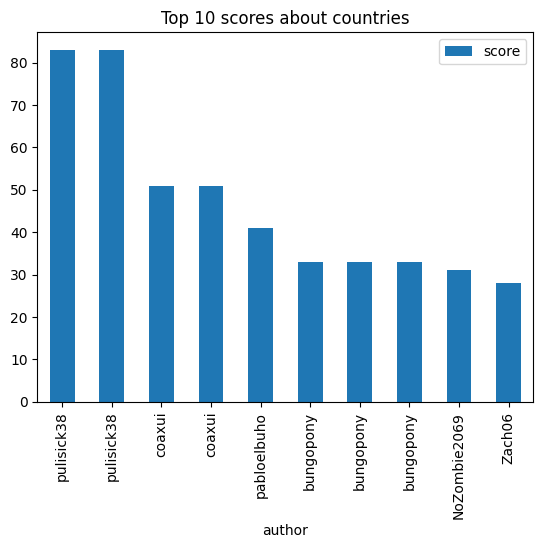

In [80]:
top_10_scores.plot(x='author', y='score', kind='bar', rot=90, title='Top 10 scores about countries')
plt.show()

In [64]:
lowest_10_scores = df_comments_pandas[["score","comment_id","author"]].sort_values(by="score",ascending=True).head(10)
lowest_10_scores

,score,comment_id,author
71,-4,n8565s9,David-J
70,-4,n8565s9,David-J
617,-4,n83iu5n,boneyqueenofnowhere
618,-4,n83iu5n,boneyqueenofnowhere
362,-4,n84cyjj,idkdudess
502,-3,n83m8mv,Afuturecruiser
504,-3,n83m8mv,Afuturecruiser
505,-3,n83m8mv,Afuturecruiser
506,-3,n83m8mv,Afuturecruiser
507,-3,n83m8mv,Afuturecruiser
